<a href="https://colab.research.google.com/github/faathirchikal/EDA/blob/master/Outlier%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hai TS sekalian! Kita akan mencoba mendeteksi dan menangani outlier

Yang pertama kita akan menggunakan data diabetes di India dan akan menghilangkan outliernya. Pertama-tama kita akan preprocessing dan menvisualisasikan data terlebih dahulu

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

In [0]:
!pip install scikit-learn
!pip install impyute
!pip install pyod

In [0]:
#Load Data
diabetes = pd.read_csv('https://raw.githubusercontent.com/DevSurya/Pima-Diabetes-Prediction/master/data/pima-data.csv')
columns = diabetes.columns
diabetes.head()

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3790,True
1,1,85,66,29,0,26.6,0.351,31,1.1426,False
2,8,183,64,0,0,23.3,0.672,32,0.0000,True
3,1,89,66,23,94,28.1,0.167,21,0.9062,False
4,0,137,40,35,168,43.1,2.288,33,1.3790,True


**Notes**: Jangan lupa untuk selalu preprocess data terutama mendeteksi missing value sebelum mendeteksi outlier!

In [0]:
#Cek apakah terdapat missing value
diabetes.describe()

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.809136
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.628517
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.906200
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.260800
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,3.900600


Pada variabel glucose_conc, diastolic_bp, thickness, insulin, bmi, skin
tidaklah mungkin bernilai 0, maka pastilah nilai nilai ini (nilai 0 pada variabel tersebut) merupakan notasi untuk menandakan bahwa tidak ada catatan mengenai variabel tersebut pada suatu pasien (missing value)

In [0]:
# Mengganti nilai 0 pada variabel diatas dengan nilai NaN
diabetes[['glucose_conc','diastolic_bp','thickness','insulin','bmi','skin']] = diabetes[['glucose_conc','diastolic_bp','thickness','insulin','bmi','skin']].replace(0,np.nan)

In [0]:
# Imputasi dengan MICE
from impyute.imputation.cs import mice
train = diabetes.drop(['diabetes'], axis=1)
columns = train.columns
imputed_training = mice(train.values)
diabetes_mice = pd.concat([pd.DataFrame(imputed_training,columns=columns),diabetes[['diabetes']]],axis=1)
diabetes_mice.head(10)

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6.0,148.0,72.00000,35.00000,222.881347,33.600000,0.627,50.0,1.379000,True
1,1.0,85.0,66.00000,29.00000,69.767640,26.600000,0.351,31.0,1.142600,False
2,8.0,183.0,64.00000,29.15342,258.149456,23.300000,0.672,32.0,1.148645,True
3,1.0,89.0,66.00000,23.00000,94.000000,28.100000,0.167,21.0,0.906200,False
4,0.0,137.0,40.00000,35.00000,168.000000,43.100000,2.288,33.0,1.379000,True
5,5.0,116.0,74.00000,29.15342,115.879146,25.600000,0.201,30.0,1.148645,False
6,3.0,78.0,50.00000,32.00000,88.000000,31.000000,0.248,26.0,1.260800,True
7,10.0,115.0,73.96229,29.15342,119.183075,35.300000,0.134,29.0,1.148645,False
8,2.0,197.0,70.00000,45.00000,543.000000,30.500000,0.158,53.0,1.773000,True
9,8.0,125.0,96.00000,29.15342,154.369649,33.324919,0.232,54.0,1.148645,True


Missing value sudah terimputasi!

Lalu, akan kita lanjutkan dengan pendeteksian outlier secara visual

In [0]:
df = diabetes_mice.drop(['diabetes'], axis=1) #nantinya untuk deteksi outlier digunakan data tanpa kolom 'diabetes' yang merupakan data kategorik
columns = df.columns
df.head()


,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin
0,6.0,148.0,72.0,35.00000,222.913091,33.6,0.627,50.0,1.379000
1,1.0,85.0,66.0,29.00000,69.768652,26.6,0.351,31.0,1.142600
2,8.0,183.0,64.0,29.15342,258.154897,23.3,0.672,32.0,1.148645
3,1.0,89.0,66.0,23.00000,94.000000,28.1,0.167,21.0,0.906200
4,0.0,137.0,40.0,35.00000,168.000000,43.1,2.288,33.0,1.379000


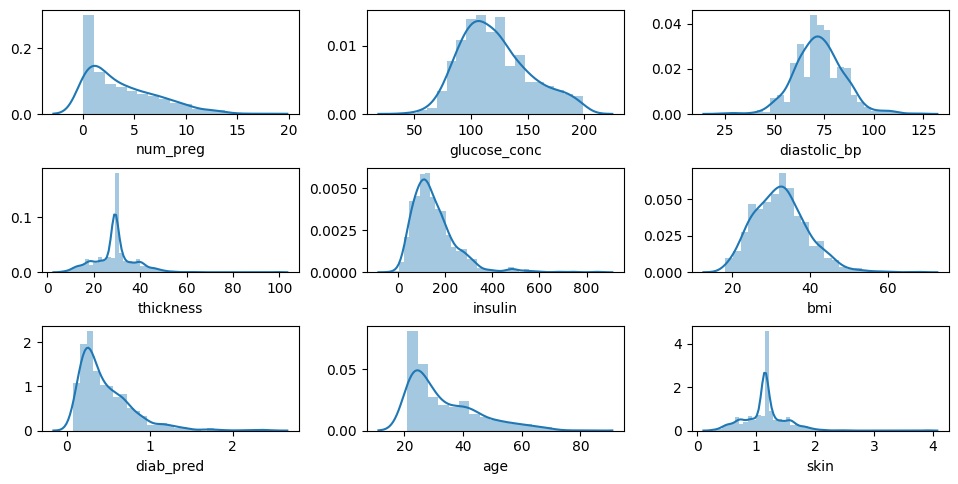

In [0]:
#Histogram seluruh variabel
fig, axes = plt.subplots(3, 3, figsize=(10, 5), dpi=100)
fig.tight_layout(pad=1.8)
for i in range(3):
  for j in range(3):
    sns.distplot(df[columns[3*i+j]],ax = axes[i,j], kde=True) #jika tidak ingin menggunakan garis kernel density kde bisa diset False 

Sebagian besar distribusi dari variabel di atas skewed

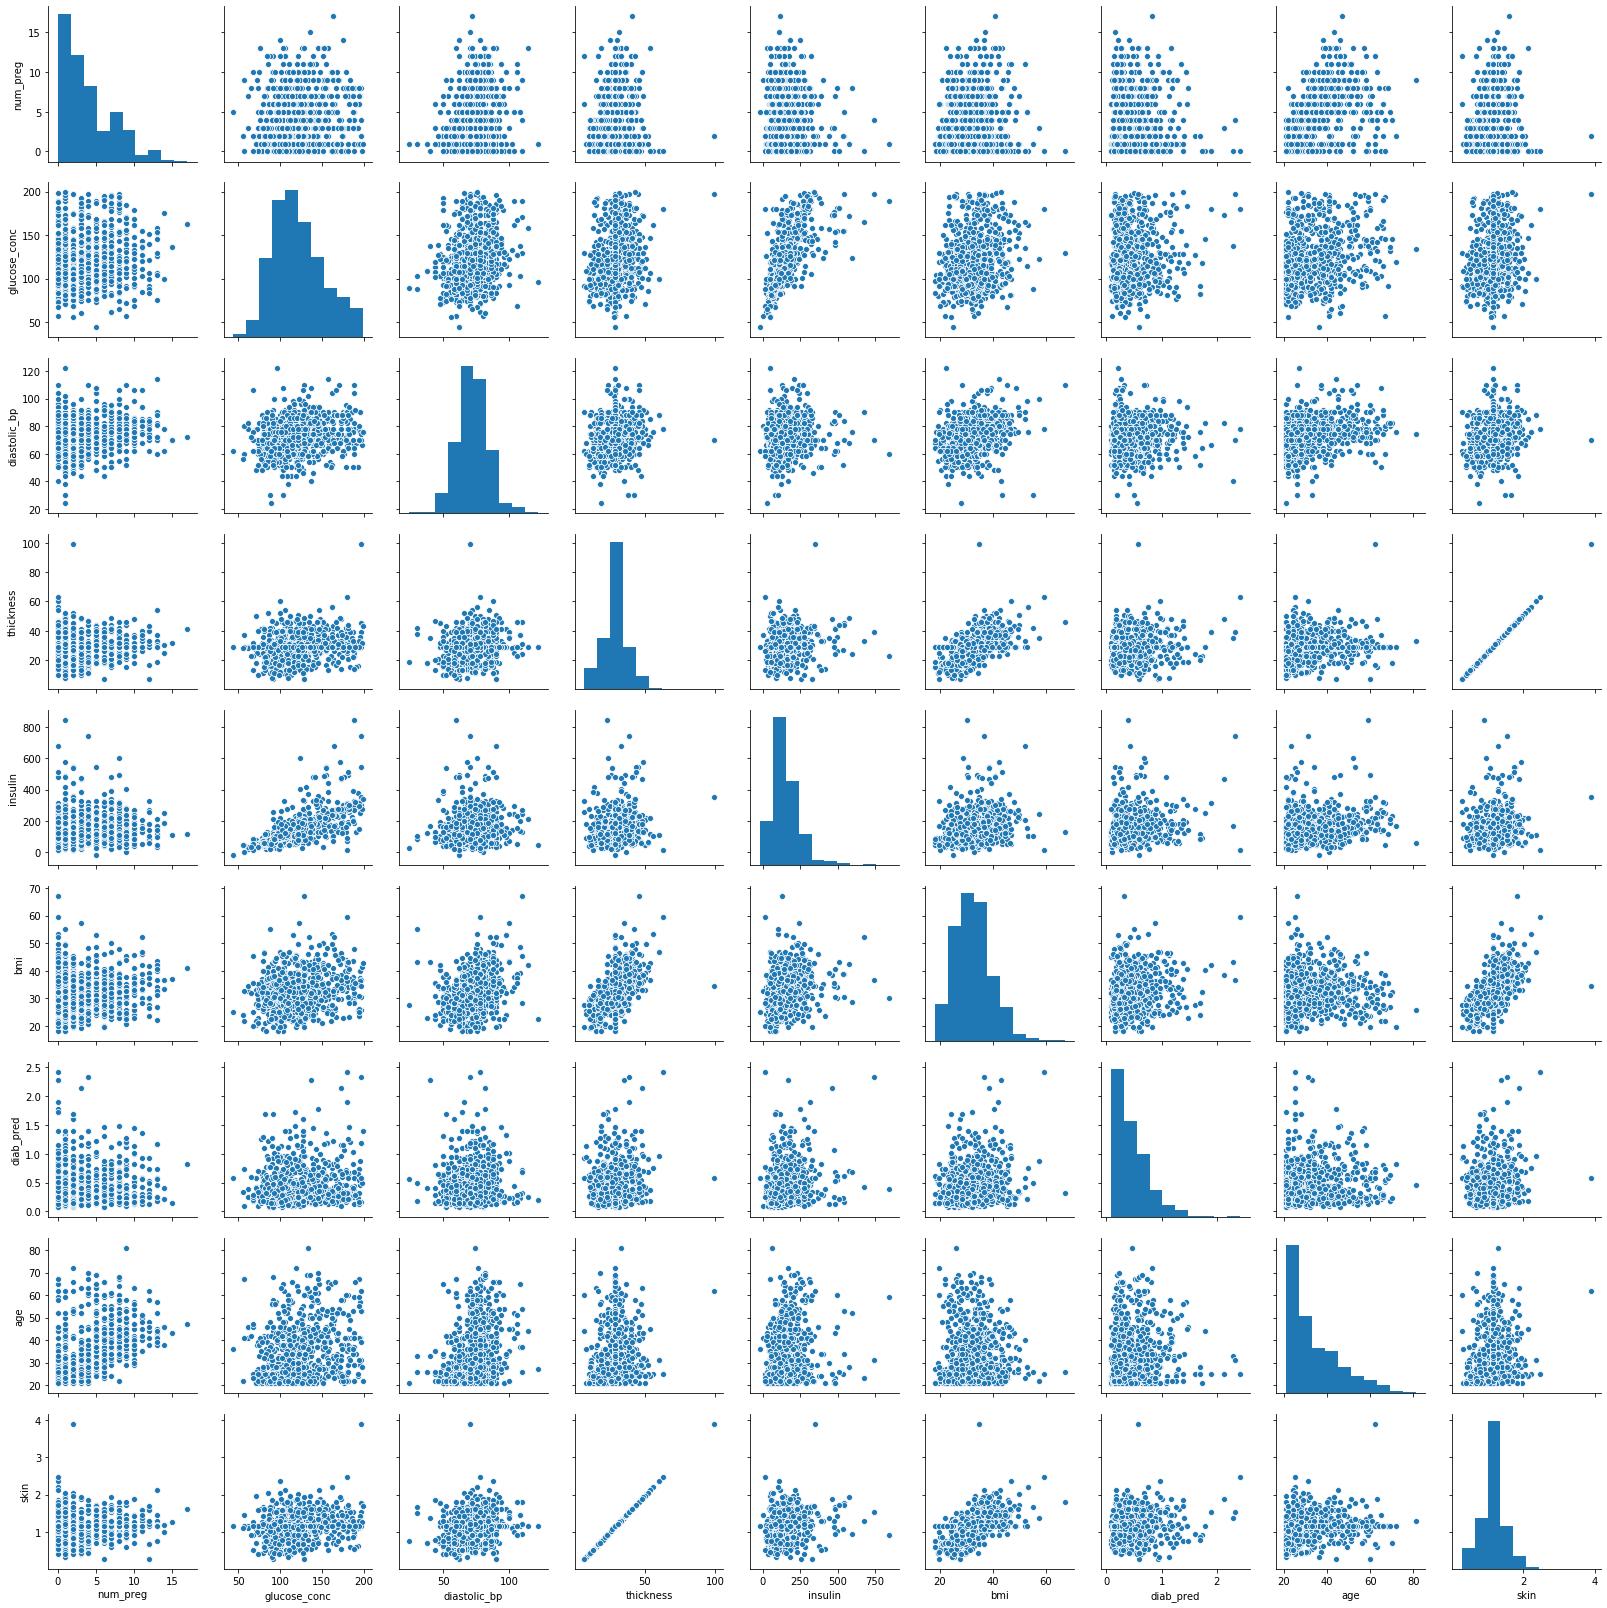

In [0]:
#Histogram dan Scatter Plot
sns.pairplot(df)

Terlihat dari scatter plot antar variabelnya, terdapat 1 atau 2 poin yang jauh dari data-data lainnya (yang berkemungkinan merupakan outlier multivariat)

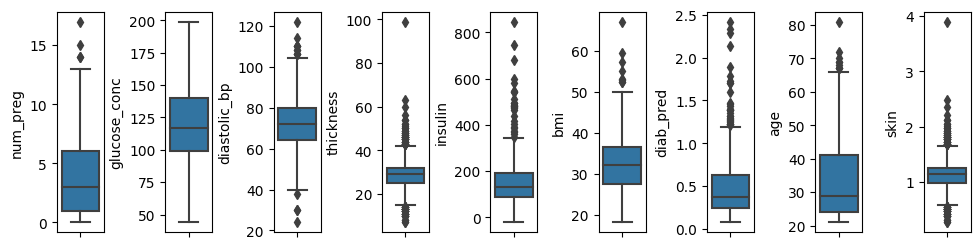

In [0]:
#Boxplot
fig, axes = plt.subplots(1, 9, figsize=(10, 3), dpi=100)
plt.tight_layout(pad=1.8)
for i in range(len(columns)):
  sns.boxplot(y=df[columns[i]],ax = axes[i])

Dari boxplot, juga dapat terdeteksi variabel mana saja yang memiliki outlier univariat. Variabel 'glucose_conc' tidak memiliki outlier

# 1. Trimming: Z-Score
> Memunculkan nilai Z-Score untuk semua data observasi diabetes




In [0]:
from scipy import stats
z = np.abs(stats.zscore(df))
print(z)

[[6.39947260e-01 8.65913435e-01 2.97648563e-02 ... 4.68491977e-01
  1.42599540e+00 6.65502121e-01]
 [8.44885053e-01 1.20359544e+00 5.23937290e-01 ... 3.65060778e-01
  1.90671905e-01 1.74633816e-02]
 [1.23388019e+00 2.01564059e+00 6.88661434e-01 ... 6.04397318e-01
  1.05584152e-01 2.56596963e-15]
 ...
 [3.42980797e-01 2.10189380e-02 2.97648563e-02 ... 6.85193357e-01
  2.75759658e-01 7.00428884e-01]
 [8.44885053e-01 1.43227798e-01 1.01810972e+00 ... 3.71101015e-01
  1.17073215e+00 6.41492408e-16]
 [8.44885053e-01 9.40800659e-01 1.94489001e-01 ... 4.73785050e-01
  8.71373930e-01 2.10191786e-01]]


Lalu kita akan tetapkan threshold sebesar 3 dan mencari outliernya

In [0]:
threshold = 3
print(np.where(z > 3))

(array([  4,   8,  13,  18,  43,  45,  57,  57,  58,  88, 106, 111, 120,
       120, 120, 123, 125, 125, 153, 159, 177, 177, 186, 220, 228, 228,
       247, 286, 298, 330, 370, 370, 371, 395, 409, 415, 445, 445, 445,
       445, 453, 455, 459, 486, 549, 579, 579, 584, 593, 597, 621, 655,
       666, 673, 684, 691, 695, 753]), array([6, 4, 4, 2, 2, 6, 3, 8, 6, 0, 2, 4, 3, 5, 8, 7, 2, 5, 4, 0, 2, 5,
       4, 4, 4, 6, 4, 4, 0, 6, 4, 6, 6, 6, 4, 4, 3, 5, 6, 8, 7, 0, 7, 4,
       2, 3, 8, 4, 6, 2, 6, 4, 7, 5, 7, 2, 4, 4]))


Array di atas menunjukkan letak outlier dalam data kita. Array pertama merupakan list dari baris dan array kedua merupakan nomor kolom.
Yang berarti z[4][6] atau data ke 4 di kolom ke 6 (variabel bmi) mempunyai z score lebih dari 3 dan merupakan outlier

In [0]:
print(z[4][6])

5.484909100466951


Lalu bagaimana cara menghilangkan outlier-outlier tersebut?

In [0]:
diabetes_o = df[(z<3).all(axis=1)]

Melihat perubahan dari jumlah data, seberapa banyak outlier yang kita buang

In [0]:
diabetes_o.shape

(721, 9)

In [0]:
df.shape

(768, 9)

Jadi, telah dibuang sebanyak 47 outlier dengan z-score dari dataset kita

**Notes**: Jika dipilih batas z score selain 3, hasilkan akan berbeda lagi

In [0]:
#Ini merupakan cara lain mendeteksi outlier dengan Scikit Learn
#Misalkan kita akan mendeteksi outlier untuk variabel insulin
from scipy.stats import zscore
df["insulin_z"] = zscore(df["insulin"])
df["is_outlier"] = df["insulin_z"].apply(
  lambda x: x <= -3 or x >= 3
)
df[df["is_outlier"]]

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,insulin_z,is_outlier
8,2.0,197.0,70.0,45.0,543.0,30.5,0.158,53.0,1.7730,3.987853,True
13,1.0,189.0,60.0,23.0,846.0,30.1,0.398,59.0,0.9062,7.076628,True
111,8.0,155.0,62.0,26.0,495.0,34.0,0.543,46.0,1.0244,3.498542,True
153,1.0,153.0,82.0,42.0,485.0,40.6,0.687,23.0,1.6548,3.396602,True
186,8.0,181.0,68.0,36.0,495.0,30.1,0.615,60.0,1.4184,3.498542,True
220,0.0,177.0,60.0,29.0,478.0,34.6,1.072,21.0,1.1426,3.325244,True
228,4.0,197.0,70.0,39.0,744.0,36.7,2.329,31.0,1.5366,6.036843,True
247,0.0,165.0,90.0,33.0,680.0,52.3,0.427,23.0,1.3002,5.384428,True
286,5.0,155.0,84.0,44.0,545.0,38.7,0.619,34.0,1.7336,4.008241,True
370,3.0,173.0,82.0,48.0,465.0,38.4,2.137,25.0,1.8912,3.192723,True


Terdapat 17 outlier dalam variabel 'insulin' (diberitahukan juga lokasi outliernya, berada di row berapa di kolom paling kiri)

## 2. Trimming: IQR

In [0]:
#Panjang IQR masing-masing variabel
df = diabetes_mice.drop(['diabetes'], axis=1) 
columns = df.columns
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

num_preg          5.0000
glucose_conc     41.2500
diastolic_bp     16.0000
thickness         7.0000
insulin         102.0000
bmi               9.1000
diab_pred         0.3825
age              17.0000
skin              0.2758
dtype: float64


In [0]:
#Menghitung jumlah data setelah di trim dengan IQR
diabetes_out = df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]
diabetes_out.shape

(611, 9)

In [0]:
df.shape

(768, 9)

Jadi, telah dibuang 157 outlier dengan IQR dari dataset kita

# 3. Winsorization
> Mengganti outlier dengan weight yang lebih kecil. Misalkan kita memilih salah satu variabel yakni 'bmi', lalu winsorize kedua variabel ini sehingga 5% dari nilai tertingginya digantikan dengan 5% upper percentilenya



In [0]:
from scipy.stats.mstats import winsorize
#Cek nilai minimum dan maksimum dari kadar insulin
df_win = diabetes_mice.drop(['diabetes'], axis=1) 
columns = df_win.columns
print(df_win['bmi'].min())
print(df_win['bmi'].max())

18.2
67.1


In [0]:
#Mengisi lower limit persentil
lower_limit =  0
#Winsorize variabel insulin

df_win['bmi_w'] = winsorize(df_win['bmi'], limits = [0, 0.05])

In [0]:
#Cek nilai maksimum dari insulin setelah di winsorize
print(df_win['bmi_w'].max())

44.5


Terlihat bahwa outlier di variabel insulin sudah tergantikan dengan nilai dengan weight lebih kecil

# 4. Pendeteksian Outlier Multivariat






**Jarak Mahalanobis**

In [0]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()
    
df_mah = diabetes_mice.drop(['diabetes'], axis=1)
df_mah['mahala'] = mahalanobis(x=df_mah, data=df_mah)
df_mah
#Ini pendeteksian outlier dengan semua variabel. Jika misal ingin hanya beberapa variabel saja misal 3 (bmi, thickness, skin):
#df_mah = df[['bmi', 'thickness', 'skin']]
#df_mah['mahala'] = mahalanobis(x=df_mah, data=df_mah[['bmi', 'thickness', 'skin']])

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,mahala
0,6.0,148.0,72.0,35.00000,222.881347,33.6,0.627,50.0,1.379000,3.533121
1,1.0,85.0,66.0,29.00000,69.767640,26.6,0.351,31.0,1.142600,3.050111
2,8.0,183.0,64.0,29.15342,258.149456,23.3,0.672,32.0,1.148645,11.906222
3,1.0,89.0,66.0,23.00000,94.000000,28.1,0.167,21.0,0.906200,3.908780
4,0.0,137.0,40.0,35.00000,168.000000,43.1,2.288,33.0,1.379000,43.483479
...,...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.00000,180.000000,32.9,0.171,63.0,1.891200,12.540804
764,2.0,122.0,70.0,27.00000,160.339446,36.8,0.340,27.0,1.063800,1.354492
765,5.0,121.0,72.0,23.00000,112.000000,26.2,0.245,30.0,0.906200,2.471692
766,1.0,126.0,60.0,29.15342,183.784318,30.1,0.349,47.0,1.148645,6.832230


In [0]:
#Critical values dengan derajat bebas n - 1 (n = jumlah variabel)
from scipy.stats import chi2
chi2.ppf((1-0.01), df=8)

20.090235029663233

In [0]:
#P-Values
df_mah['p_value'] = 1 - chi2.cdf(df_mah['mahala'], 8)

#Extreme values dengan tingkat signifikansi 0.01
sig = df_mah.loc[df_mah.p_value < 0.01]
sig

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,mahala,p_value
4,0.0,137.0,40.000000,35.00000,168.000000,43.1,2.288,33.0,1.379000,43.483479,7.121763e-07
8,2.0,197.0,70.000000,45.00000,543.000000,30.5,0.158,53.0,1.773000,29.338268,2.765395e-04
13,1.0,189.0,60.000000,23.00000,846.000000,30.1,0.398,59.0,0.906200,74.342165,6.680212e-13
18,1.0,103.0,30.000000,38.00000,83.000000,43.3,0.183,33.0,1.497200,26.514280,8.572379e-04
39,4.0,111.0,72.000000,47.00000,207.000000,37.1,1.390,56.0,1.851800,23.835371,2.442036e-03
45,0.0,180.0,66.000000,39.00000,313.977726,42.0,1.893,25.0,1.536600,24.951209,1.584428e-03
58,0.0,146.0,82.000000,29.15342,247.619775,40.5,1.781,44.0,1.148645,20.595879,8.302051e-03
86,13.0,106.0,72.000000,54.00000,111.462423,36.6,0.178,45.0,2.127600,46.602889,1.825227e-07
106,1.0,96.0,122.000000,29.15342,45.234090,22.4,0.207,27.0,1.148645,32.370265,7.993785e-05
120,0.0,162.0,76.000000,56.00000,100.000000,53.2,0.759,25.0,2.206400,24.531443,1.865576e-03


In [0]:
#Menghitung jumlah outlier
len(sig)

43

Jarak Mahalanobis mendeteksi sebanyak 43 outlier

**DBSCAN**

In [0]:
#Pertama-tama mari kita lihat korelasi antara variabelnya
df = diabetes_mice.drop(['diabetes'], axis=1)
cor = df.corr()
pd.DataFrame(cor)

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin
num_preg,1.000000,0.130283,0.214227,0.082989,0.048386,0.022527,-0.033523,0.544341,0.082989
glucose_conc,0.130283,1.000000,0.230697,0.195617,0.700257,0.234848,0.138774,0.269138,0.195617
diastolic_bp,0.214227,0.230697,1.000000,0.192535,0.140633,0.296421,0.001456,0.333998,0.192535
thickness,0.082989,0.195617,0.192535,1.000000,0.199776,0.542613,0.100966,0.127872,1.000000
insulin,0.048386,0.700257,0.140633,0.199776,1.000000,0.280881,0.152188,0.229111,0.199776
bmi,0.022527,0.234848,0.296421,0.542613,0.280881,1.000000,0.153296,0.026562,0.542613
diab_pred,-0.033523,0.138774,0.001456,0.100966,0.152188,0.153296,1.000000,0.033561,0.100966
age,0.544341,0.269138,0.333998,0.127872,0.229111,0.026562,0.033561,1.000000,0.127872
skin,0.082989,0.195617,0.192535,1.000000,0.199776,0.542613,0.100966,0.127872,1.000000


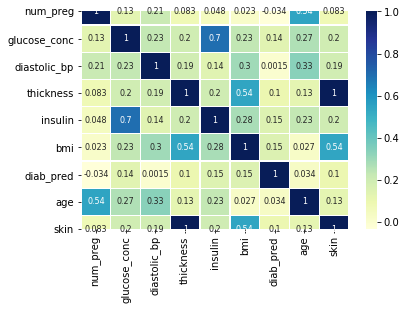

In [0]:
#Heatmap
sns.heatmap(cor,
            annot=True,
            cmap="YlGnBu", 
            linewidths=0.3,
            annot_kws={"size": 8})
# Plot aesthetics
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Disini terlihat bahwa glucose_conc dan insulin mempunyai korelasi yang kuat (0.7), lalu age dan num_preg, thickness dan bmi, serta bmi dan skin mempunyai korelasi moderat (sedang) (0.54)

**Notes**: Untuk variabel-variabel ini ada baiknya menggunakan jarak mahalanobis

In [0]:
#DBSCAN dengan jarak mahalanobis (karena beberapa variabel dalam data terdapat korelasi yang cukup kuat, lebih disarankan menggunakan mahalanobis)
df = diabetes_mice.drop(['diabetes'], axis=1)
columns = df.columns
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
  eps = 1.5, #jarak maksimum antara dua poin
  metric='mahalanobis',
  min_samples = 3, #jumlah minimal poin agar terbentuk satu dense cluster
  n_jobs = -1, algorithm='brute')
clusters = outlier_detection.fit_predict(df)

clusters

array([ 0,  0, -1,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0

In [0]:
#Array dengan angka -1 merupakan outlier
#Lalu akan ditambahkan pendeteksian ini sebagai kolom baru di dataset diabetes
df_db = diabetes_mice.drop(['diabetes'], axis=1)
df_db['is_outlier'] = clusters == -1
print(df_db)

     num_preg  glucose_conc  diastolic_bp  ...   age      skin  is_outlier
0         6.0         148.0          72.0  ...  50.0  1.379000       False
1         1.0          85.0          66.0  ...  31.0  1.142600       False
2         8.0         183.0          64.0  ...  32.0  1.148645        True
3         1.0          89.0          66.0  ...  21.0  0.906200       False
4         0.0         137.0          40.0  ...  33.0  1.379000        True
..        ...           ...           ...  ...   ...       ...         ...
763      10.0         101.0          76.0  ...  63.0  1.891200       False
764       2.0         122.0          70.0  ...  27.0  1.063800       False
765       5.0         121.0          72.0  ...  30.0  0.906200       False
766       1.0         126.0          60.0  ...  47.0  1.148645       False
767       1.0          93.0          70.0  ...  23.0  1.221400       False

[768 rows x 10 columns]


In [0]:
pd.value_counts(df_db['is_outlier'].values, sort=False)

False    720
True      48
dtype: int64

DBSCAN dengan jarak mahalanobis mendeteksi 48 outlier

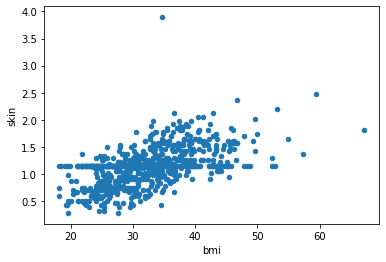

In [0]:
#Diatas mendeteksi untuk semua variabel yang ada dalam dataset diabetes
#Lalu, misalkan kita mau mendeteksi outlier multivariat antara dua variabel dan memvisualisasikannya. Kita memilih variabel bmi dan skin dan mencari outlier dari dataframenya
#Pertama-tama kita akan membuat scatter plotnya
bmiskin = df[["bmi", "skin"]]
bmiskin.plot.scatter(x = "bmi", y = "skin")

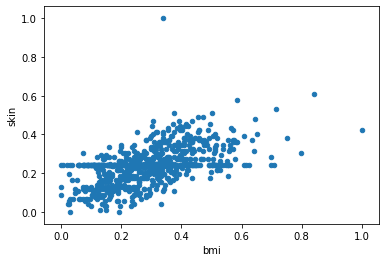

In [0]:
#karena kedua variabel memiliki skala yang berbeda, maka akan dinormalisasi
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
bmiskin = scaler.fit_transform(bmiskin)
bmiskin = pd.DataFrame(bmiskin, columns = ["bmi", "skin"])
bmiskin.plot.scatter(x = "bmi", y = "skin")

In [0]:
#Lalu gunakan kembali pendeteksian DBSCAN dengan jarak mahalanobis
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
  eps = 1.5,
  metric='mahalanobis',
  min_samples = 2,
  n_jobs = -1, algorithm='brute')
clusters_bmiskin = outlier_detection.fit_predict(bmiskin)

clusters_bmiskin

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

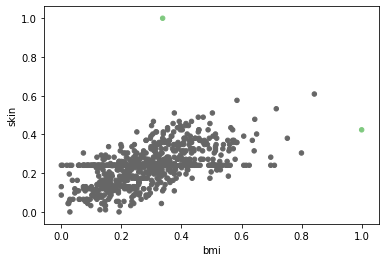

In [0]:
#Lalu visualisasikan outlier dari bmi dan skin
from matplotlib import cm
cmap = cm.get_cmap('Accent')
bmiskin.plot.scatter(
  x = "bmi",
  y = "skin",
  c = clusters_bmiskin,
  cmap = cmap,
  colorbar = False
)

Terlihat ada 2 outlier multivariat antara bmi dan skin

**Isolation Forest**

In [0]:
# Isolation Forest for Outlier Detection
from pyod.models.iforest import IForest
# Fitting isolation forest
isolation_forest = IForest(behaviour="new", random_state=42)
isolation_forest.fit(X=df)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=42,
    verbose=0)

In [0]:
isolation_forest.predict(X=df)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [0]:
#Array dengan angka 1 merupakan outlier
#Lalu akan ditambahkan pendeteksian ini sebagai kolom baru di dataset diabetes
df_iso = diabetes_mice.drop(['diabetes'], axis=1)
df_iso['is_outlier'] = isolation_forest.predict(X=df) == 1
print(df_iso)

     num_preg  glucose_conc  diastolic_bp  ...   age      skin  is_outlier
0         6.0         148.0          72.0  ...  50.0  1.379000       False
1         1.0          85.0          66.0  ...  31.0  1.142600       False
2         8.0         183.0          64.0  ...  32.0  1.148645       False
3         1.0          89.0          66.0  ...  21.0  0.906200       False
4         0.0         137.0          40.0  ...  33.0  1.379000        True
..        ...           ...           ...  ...   ...       ...         ...
763      10.0         101.0          76.0  ...  63.0  1.891200        True
764       2.0         122.0          70.0  ...  27.0  1.063800       False
765       5.0         121.0          72.0  ...  30.0  0.906200       False
766       1.0         126.0          60.0  ...  47.0  1.148645       False
767       1.0          93.0          70.0  ...  23.0  1.221400       False

[768 rows x 10 columns]


In [0]:
pd.value_counts(df_iso['is_outlier'].values, sort=False)

False    691
True      77
dtype: int64

Isolation Forest mendeteksi sebanyak 77 outlier

Demikian, contoh beberapa pendeteksian dan penanganan outlier yang dapat dilakukan. Namun, perlu diketahui bahwa **tidak ada metode yang paling benar dalam mendeteksi dan menangani outlier**, tergantung pada kondisi, konteks, dan big picture yang ingin disampaikan dari data. 

#Selamat mencoba!